In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import math
import networkx as nx
import sys
import matplotlib.pyplot as plt
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [3]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Colouring data & results\\"
proj_crs = "EPSG:7856"

place = 'Sydney, Australia'
place_gdf = ox.geocode_to_gdf(place).to_crs(proj_crs)

#place_gdf = gpd.read_file(folder + 'Canberra Data\\Canberra Metro SA3s.gpkg', crs="EPSG:4326").to_crs(proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

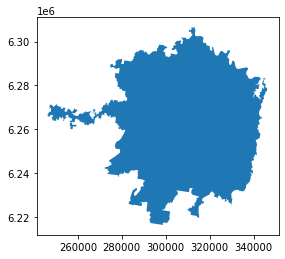

In [14]:
# check that we have the right area
place_gdf.geometry.plot()

## Import Data

Data sources:
1. OSM POIs
5. Employment data - find govt source

In [4]:
poi_dictionary = {
    'employment':{
        'category':['employment']
    },
    'shopping':{
        'shop':['bakery', 'clothes', 'supermarket', 'mall', 'greengrocer',
                'seafood', 'wine', 'butcher','convenience',
                'beverages', 'alcohol', 'bicycle_shop', 'department_store', 
                'doityourself', 'beauty_shop', 'outdoor_shop', 
                'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                'car_dealership', 'furniture_shop', 'sports_shop',
                'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
        # possibly we could pick up all shop=True excluding a few. but not sure how
        # and many options to exclude
        'amenity':['marketplace'],
        'building':['kiosk', 'supermarket',],
    },
    'errands':{
        'amenity':['atm','bank','courthouse','post_box', 'post_office',
                   'clinic', 'dentist', 'doctors', 'hospital',
                   'pharmacy', 'veterinary', 'travel_agent',
                   'place_of_worship'],
        'shop':['optician', 'hairdresser', 'laundry',],
        'healthcare':['physiotherapist'],
        'office':['government'], #### further refine ?
    },
    'recreation':{
        'leisure':['dog_park', 'ice_rink', 'park', 'pitch', 'playground',
                   "fitness_centre","sports_centre", 'stadium', 'swimming_pool',
                   'swimming_area', 'track', 'water_park','golf_course',],
        'club':['social'],
        'amenity':['bar', 'biergarten', 'cafe', 'fast_food', 'food_court',
                   'ice_cream', 'pub', 'restaurant', 'nightclub',
                   'library', 'arts_centre', 'cinema', 'community_centre',
                   'social_centre', 'theatre',],
        'building':['stadium', 'castle', 'ruins',],
        'tourism':['aquarium', 'artwork', 'attraction', 'gallery',
                   'museum', 'picnic_site', 'theme_park', 'viewpoint',
                   'zoo'],
        'natural':['beach'],
    },
    'education':{
        'amenity':['college', 'kindergarten', 'music_school',
                   'school', 'university', 'childcare'],
    }
}

In [5]:
osm_pois = poi_downloader(place_gdf, poi_dictionary, proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [8]:
employment_centrs = gpd.read_file((folder + 
                        "Sydney Data\\Data\\Centroids employment MBs.gpkg")).to_crs(proj_crs)

employment_centrs['category'] = 'employment'
employment_centrs['geometry'] = employment_centrs.geometry.centroid

Need to remove potential overlap between different data sources (and inside some data sources). For now I'm not worrying about this when using only OSM data. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [9]:
pois = pd.concat([osm_pois, employment_centrs])

pois = gpd.clip(pois, place_gdf.to_crs(proj_crs))

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [10]:
poi_parameters = pd.read_csv((folder + 
                              "Shared Aus Data\\poi_parameters_5.csv"),
                            index_col=0)

In [15]:
poi_weights = poi_parameters['weight'].copy()

poi_lambdas = poi_parameters['diminishing_returns_constant'].copy()

poi_variables = poi_parameters['variable'].copy()

poi_nums = poi_parameters['num_pois'].copy()

poi_gammas = poi_parameters['distance_constant'].copy()

In [12]:
total = sum(poi_weights)
print("total: ", total)

total:  100.00000000000001


In [27]:
# change this to match the column containting job counts in your employment dataframe
poi_variables.loc['employment'] = 'Jobs_count'
# change this to make employment score more accurate (higher number) or to reduce index calculation time (low number)
poi_nums.loc['employment'] = 1200

### Import network

Pandana expects edges to have a two item index based on the same IDs as the node index. (with thanks to https://github.com/shriv/accessibility-series/blob/master/Accounting%20for%20hills%20in%20accessibility%20analyses.ipynb)

In [19]:
#G = ox.graph_from_place(place, network_type='walk')
G = ox.graph.graph_from_polygon(place_gdf.to_crs('EPSG:4326').geometry[0], network_type='walk')

In [20]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [21]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

## Pandana network creation.

In [22]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
distance_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

### Pandana network querying. 

In [23]:
maximum_dist=2400

In [28]:
results_walk = there_index(distance_network, pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: employment
Maximum score: 20.96687824711857 out of 31.9


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: education
Maximum score: 14.288600466795097 out of 14.3


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: shopping
Maximum score: 21.58805337760481 out of 21.6


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: errands
Maximum score: 8.892357784372647 out of 8.9


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: recreation
Maximum score: 23.287113134175556 out of 23.3


In [29]:
max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index'])

(87.5537861075623, 46.735377568329355)

The current approach is to find up to x closest nodes for each category within the maximum distance. Then look up the attractiveness at each one (just count for most), apply a distance decay function to each distance, apply diminishing returns to the resulting total opportunity, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance including applying a decay function. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

## Export results

Reduce the number of decimal places before export, distances do not need to be below 1m.

In [37]:
def result_rounding(results):
    # reduces results size for export
    # score columns such as THERE_Index, employment_subtotal etc -> 3 decimal places
    # distance columns such as employment1 -> 0 decimal places (nearest metre)
    # avoid doing anything to connect_id, x or y
    rounding_dict = {**{k:3 for k in results.columns if "Index" in k or "." in k
                        and 'connect_id' not in k},
                     **{k:0 for k in results.columns if "Index" not in k and "." not in k
                        and k != 'x'
                        and k != 'y'}}
    return results.round(rounding_dict)

In [38]:
small_w_results = gpd.GeoDataFrame(result_rounding(results_walk), geometry = gpd.GeoSeries.from_xy(results_walk.x, results_walk.y, crs=proj_crs))

 ### Population weighted results

Import smallest statistical unit for which population data is available (meshblocks in Australia). Join this to the results (by population weighted centroid location if available, otherwise geometric centroid location). Then results can be graphed or visualised by population, giving a more accurate picture of the population access by walking.

In [30]:
meshblocks = gpd.read_file(folder + "Sydney Data\\Data\\2016_NSW_MBs\\MB_2016_NSW.shp").to_crs(proj_crs)
meshblocks['MB_CODE16'] = meshblocks['MB_CODE16'].astype('int64')
meshblocks.geometry = meshblocks.centroid

In [31]:
population = pd.read_csv(folder + "Sydney Data\\Data\\2016_NSW_MBs\\2016 census mesh block counts.csv")
population = population.set_index('MB_CODE_2016')

In [33]:
meshblocks = meshblocks.join(population, on='MB_CODE16', how='left')

In [39]:
meshblocks_w = meshblocks.sjoin_nearest(small_w_results, how='left', rsuffix = 'walk')
meshblocks_w = meshblocks_w.clip(place_gdf)

Population weighted average THERE index:

In [51]:
sum(meshblocks_w['Person']*meshblocks_w['THERE_Index'])/sum(meshblocks_w['Person'])

49.55207454204555

Text(0.5, 0.98, 'Sydney: distribution of results by residential population')

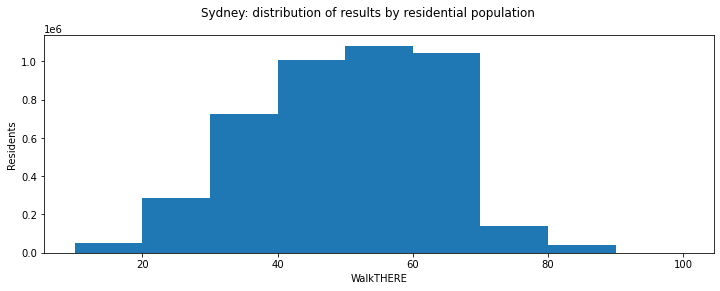

In [52]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
#f.set_figwidth(4)
bins=[10,20,30,40,50,60,70,80,90,100]
ax1.hist(meshblocks_w['THERE_Index'], weights = meshblocks_w['Person'], label='WalkTHERE',bins=bins)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')

fig.suptitle('Sydney: distribution of results by residential population')

### Visualise results

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

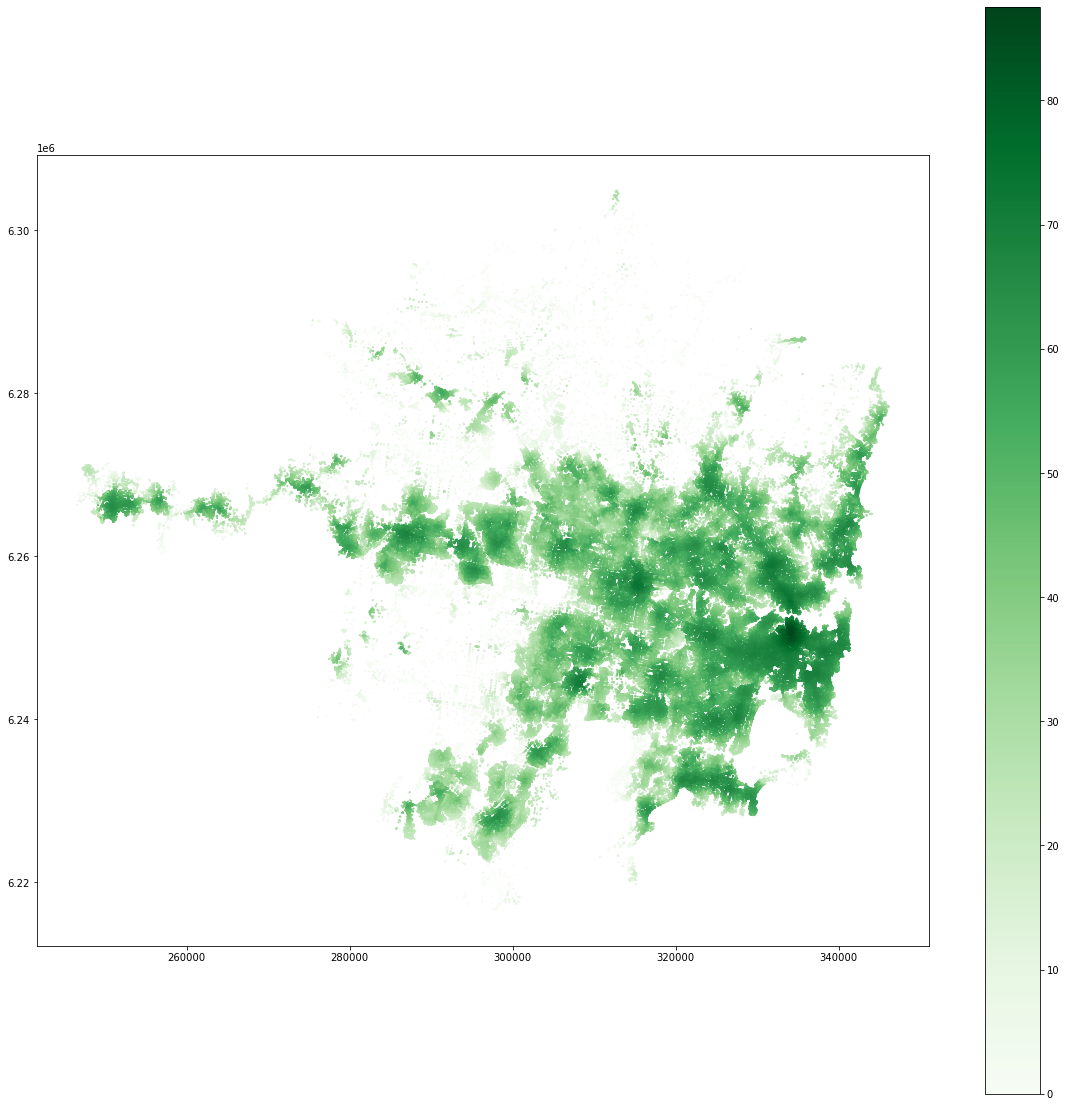

In [72]:
small_w_results.plot(column="THERE_Index", legend=True,
                     cmap='Greens',figsize=(20,20),markersize=1)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

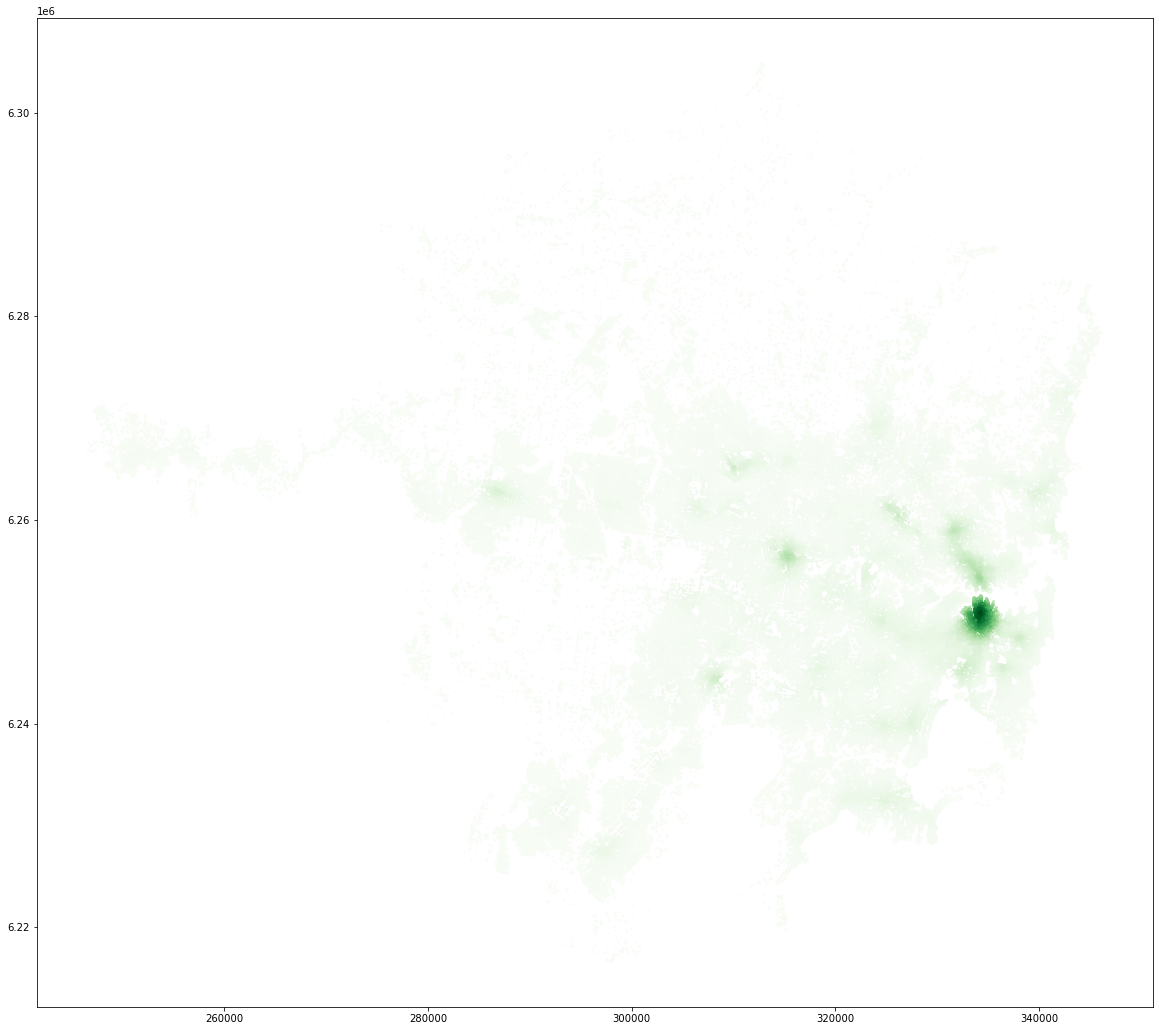

In [70]:
small_w_results.plot(column="employment_31.9", cmap='Greens',figsize=(20,20),markersize=1)

In [61]:
meshblocks_w.to_file((folder + "Sydney Data\\Sydney MB results walk 190722.gpkg"))

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:
